## We no want Gwen to Die

Gwen Stacy is Spiderman's formerly alive ex-girlfriend. That's sad. He didn't even get to break up with her. She died. In his arms. At his hands.

The scenario begins as such: Spiderman is fighting the green goblin (not the hobgoblin, he hasn't made any movie appearances yet), in a giant clock tower. Gwen Stacy (SpyderBoi's, at the time, living girlfriend) was dangling from his web in the clcok. Well as expected, Spiderbuddy makes a wrong step, the web breaks, the clock breaks, and Gwen is accelerating towards the ground with giant metal gears and clocks. Spiderman dives, shoots his web at her, and then he grabs onto a metal bar, stopping himself, but leaving her survival solely on the physics of her body and the web. In case it wasn't clear, she died. 

In the movie, the web attached to her abdomen as she was falling, and she died because her head hit the floor with too great of an acceleration. In other words, SpideyBoi was just a wee bit too slow to be the be the cool guy that beats the villain and gets the girl. Realistically, we wanted to model the forces and motion of this fall, to determine how she could have survived if she hadn't hit the ground. This would require the force of tension in the web to be less than what's necessary to break a human spine. 

Our goal is to determine the optimal catch time for Gwen Stacy's mortal vessel along with optimal elasticity for spiderman's webs. 

Varying change in time (time from max v to 0 m/s) through swept values or ODE solver (in which would vary the force exerted on her body). This would be the amount of time it took for Gwen Stacy's mortal vessel to stop falling once she was caught by the web that could've broken her spine if she had not busted her head on the ground. 

If we sweep change in time values for velocity, we would have control over the amount of time it would take for her to stop falling. Using ODE solver would allow for us to stop the simulation once a lethal amount of force is exerted upon her human vessel (thus causing unaliving). 


### Question?

What would be the optimal time to catch Gwen Stacy as she was falling from the clock tower so that she could survive the forces on her body?

### Model Functions and Test Run

Below begins the configuration and the continuation of our model, you will find all the secondary and smaller functions used in our model written and defined in this section.

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newtons

<Unit('newton')>

In this model, we are tracking position and velocity. So, we are going to prepare for this by writing functions that will graph these variables, as well as Force which is the most important aspect of her fall, because it shows whether or not she lives.

In [4]:
def plot_position(results):
    plot(results.height) #plots height
    decorate(xlabel='Time (s)', #labels x-axis as Time(s)
             ylabel='Position (m)') #labels y-axis Position (m)
    

In [5]:
def plot_velocity(results):
    plot(results.velocity, color='C1', label='v') #plots velocity
        
    decorate(xlabel='Time (s)', #labels x-axis as Time(s)
             ylabel='Velocity (m/s)') #labels y-axis Velocity (m/s)

In [27]:
def plot_force(results):
    plot(results, 'o', color='C1', label='Force', markersize=10) #plots velocity
        
    decorate(xlabel='Spring Constant', #labels x-axis as Time(s)
             ylabel='Force (N)') #labels y-axis Velocity (m/s)

As you can see in the Params function below, there are certain assumptions we make in this model, the most primary of which is that upon a broken spine we assume Gwen will die. We also assume that spider-man stays at a constant height, and doesn't dive after Gwen like in the movie. Many other values, such as gwen stacey's weight were found from different marvel databases and values such as height of the building and density, etc., were chosen based on estimations based on the movie or physics sites. The spring consant value is what is being sweeped overall, so the value shown below is purely for testing purposes.

In [28]:
params = Params( 
    g = 9.81* m / s**2, #gravity
    forceOfDeath = 3000 * N, #amount of force found to break a human spine
    k = 10e2*N/m, #arbitrary spring constant value
    terminal_velocity = 53 * m /s, #terminal velocity of a human being
    height_building = 100 * m, #height of the building, a.k.a. initial height
    L = 50 * m, #Length of webbing when spiderman goes for the catch, we assume that this length is perfect due to Spider Senses
    mass = 59*kg,
    rho = 1.2 * kg/m**2, #density
    area = 1 * m**2 
    )

,values
g,9.81 meter / second ** 2
forceOfDeath,3000 newton
k,1000.0 newton / meter
terminal_velocity,53.0 meter / second
height_building,100 meter
L,50 meter
mass,59 kilogram
rho,1.2 kilogram / meter ** 2
area,1 meter ** 2


In [29]:
def make_system(params): #Fairly self explainatory
    unpack(params)
    init = State(height = height_building, velocity = 0*m/s)
    
    C_d = 2 * mass * g / (rho * area * terminal_velocity**2)
    t_end = 15 * s
    
    return System(params, C_d = C_d, 
                  init = init, t_end = t_end)

In [30]:
system = make_system(params) #system used for this test run

,values
g,9.81 meter / second ** 2
forceOfDeath,3000 newton
k,1000.0 newton / meter
terminal_velocity,53.0 meter / second
height_building,100 meter
L,50 meter
mass,59 kilogram
rho,1.2 kilogram / meter ** 2
area,1 meter ** 2
C_d,0.3434140263438947 1 / meter


Below is the function we used to calculate the force at every given height

In [31]:
def force_spring(system, height):
    
    unpack(system)   
    
    delta_height = height_building - height
    if delta_height < L:
        return 0 * N
    stretch_length = delta_height - L
    spr_force = k * stretch_length
    #print(spr_force)
    return spr_force


Below is the function we use to calculate the Drag Force at given velocities

In [32]:
def force_drag(system, velocity):
    
    unpack(system)
    
    f_drag = -np.sign(velocity) * rho * velocity**2 * C_d * area / 2
    return f_drag

Below is slope function that we use for our ode solver, in which we find the velocity and acceleration at each time step, based on the forces at the velocities and heights based on time.

In [33]:
def slope_func(state, time, system):
    
    y, velocity = state
    
    unpack(system)
    
    a_spring = force_spring(system, y) / mass #Finds acceleration due to the Spring Force / Mass
    a_drag = force_drag(system, velocity) / mass #Finds acceleration due to the Drag Force / Mass
    
    acceleration = -g + a_spring + a_drag #Calculates the net acceration based on gravity, spring acceleration and drag acceleration
    
    return velocity, acceleration
    

This event function returns when the height is 0, so that way Gwen doesn't go crashing through a ground that doesn't exist. 

In [34]:
def event_func(state, time, system):
    y, velocity = state
    
    return y
    

Finally we run through the ODE solver

In [35]:
results, details = run_ode_solver(system, slope_func, max_step = .1 * s, events = event_func)
results

,height,velocity
0.000000,100.000000,0.000000
0.000102,100.000000,-0.001000
0.001121,99.999994,-0.011000
0.011315,99.999372,-0.110999
0.111315,99.939226,-1.091844
0.211315,99.781028,-2.071942
0.311315,99.524885,-3.050623
0.411315,99.170973,-4.027221
0.511315,98.719532,-5.001076
0.611315,98.170871,-5.971536


### Test Results

Below you will see the results of this test run. 

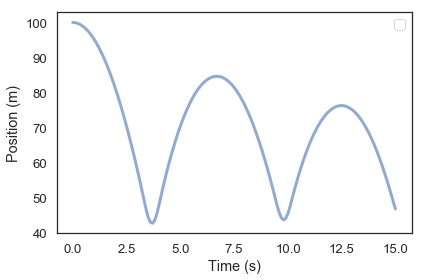

In [36]:
plot_position(results) ##Here is position

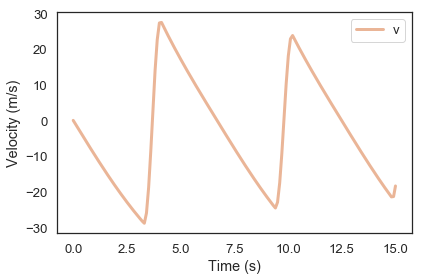

In [37]:
plot_velocity(results) #Here is velocity

Here you see we manipulate the velocity data, to find the acceleration at each timestep. Then we record the maximum acceleration throughout the run, to find the maximum force.

<Quantity(112.95561602336039, 'meter / second ** 2')>

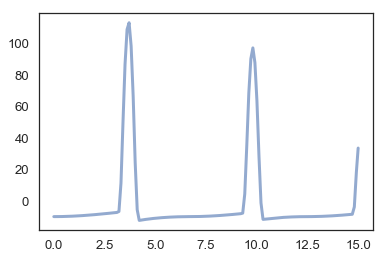

In [38]:
accel3 = gradient(results.velocity)
plot(accel3)
max_acceleration = max(accel3) * m/s**2

The maximum force is important, since it's the maximum value of acceleration it allows us to determine Gwen's Surival based on whether or not the force is greater than or equal to the force required to break a human spine. 

In the movie, the web attached to her abdomen as she was falling, and she died because her head hit the floor with too great of an acceleration. Realistically, we wanted to model the forces and motion of this fall, to determine how she could have survived if she hadn't hit the ground. This would require the force of tension in the web to be less than what's necessary to break a human spine. 

In [39]:
max_force = max_acceleration * system.mass

<Quantity(6664.381345378263, 'kilogram * meter / second ** 2')>

## Functions used in the Higher Level Sweep

Now we begin the portion of our code which actually runs the simulation. The code above shows the steps the following code will take for each run. 
Directly below is the State function we use to keep track of important variables.

In [40]:
track = State(force = 0)

,values
force,0


This is the main function. It sweeps the spring constant of Spiderman's web, and assumes that he always catches Gwen 50 m into her fall with a 50 m long web. For each spring constant, this function also outputs a graph showing how height and velocity were affected. 


In [41]:
def sweep_k(state, params, make_sys, slope_func, event_func):
    unpack(params)
    series = SweepSeries()#establishes the number of cells per
                                           #cell type as a Time Frame
        
    k_array = [7.74, 7.74e2, 7.74e3, 7.74e4] #These are the values we are sweeping through for the spring constant

    for k in k_array: #counts how many steps we need to run
                                       #through and how many we have ran through
        params = Params( 
          g = 9.81* m / s**2,
          forceOfDeath = 3000 * N,
          k = k*N/m,
          terminal_velocity = 53 * m /s,
          height_building = 100 * m,
          L = 50*m,
          mass = 59*kg,
          rho = 1.2 * kg/m**2,
          area = 1 * m**2
          )
        
        system = make_system(params) #Makes the system
        
        results, details = run_ode_solver(system, slope_func, max_step = .1 * s,
                                          events = event_func) #records the 
                                                         #results from each step
        velocity = max(results.velocity) #max velocity from that event
        acceleration = gradient(results.velocity) #accelerations from last event
        max_acceleration = max(acceleration) * m/s**2 #max accel
        max_force = (max_acceleration * system.mass).to(UNITS.newtons) #max force
        
        fig1, ax1 = plt.subplots() #I am not completely certain what this does, but I don't want to break it
        ax1.plot(results.height) #Plots the height of Gwen during this run against time
        ax1.set_title("Height vs Time with Spring Constant: " + str(k)) #Sets the title
        ax1.set_ylabel("Height") #Sets the Y axis Label
        ax1.set_xlabel("Time") #Sets the X axis Label

        fig2, ax2 = plt.subplots() # Again, not completely sure...
        ax2.plot(results.velocity) #Plots the velocity of Gwen during this run against time
        ax2.set_title("Velocity vs Time with Spring Constant: " + str(k)) #Sets the title
        ax2.set_xlabel("Time") #Sets the x label
        ax2.set_ylabel("Velocity") #Sets the y label
        
        
        series[k] = max_force.magnitude #Records the maximum force over this run
        
      
    #returns the final Time Frame, which contains the number of cells for each step through
    return series

## Results
Now we run the simulation and hope that it works. We expect to see a graph showing height vs time and velocity vs time, for each k value we sweep. If the Force at any K value surpasses 3000N, the force necessary to break a human spine, or her height reaches 0, then we can assume that Gwen, sadly, did not make it. 

,values
7.74,34.714033
774.00,5892.408292
7740.00,15277.433609
77400.00,50178.561856


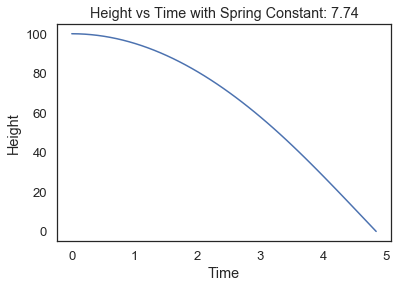

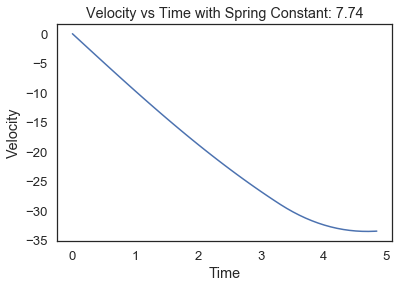

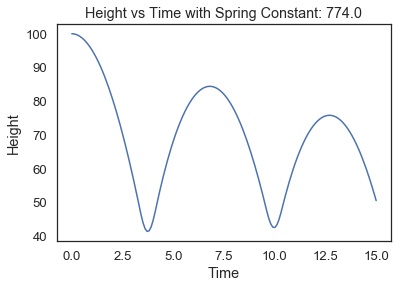

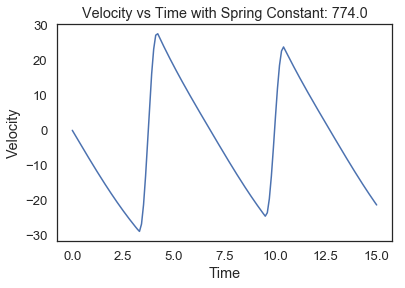

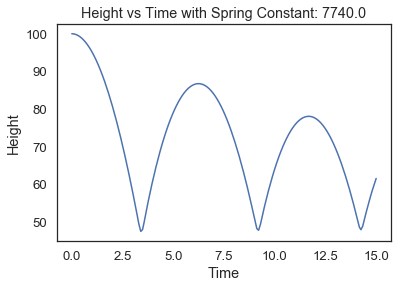

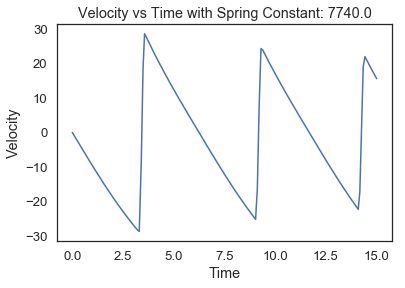

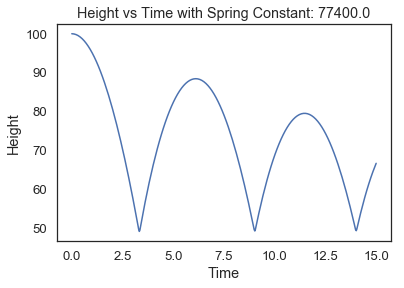

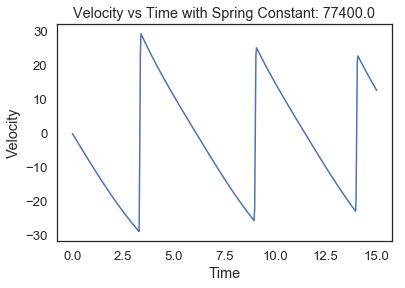

In [42]:
data = sweep_k(track, params, system, slope_func, event_func)

As you can see in the graph's above, regardless of the spring constant, Gwen's fall is going to be hell. 
For the lower Spring Constant she fell straight into the ground. This is death because the force of her body hitting the ground would have killed her at such speeds. 
For higher spring constants, the force is so high that her spine would snap.
Poor Gwen...

,values
7.74,34.714033
774.00,5892.408292
7740.00,15277.433609
77400.00,50178.561856


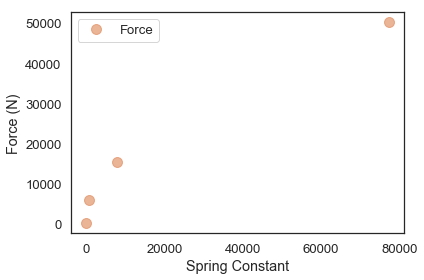

In [43]:
plot_force(data)

data

### Interpretation

We were divided on the answer to this modeling question. Naturally, I, the Jerry Goss, have no faith in SpiderTeen's ability to save a girl who didn't have verifiable feelings for him (him being a fairly poor rendition of Spiderman with weird facial expressions). I think Gwen Stacy would have died in all of the arguably realistic scenarios. 

Since we swept over k values (spring constants), for spiderman's webs. The initial k value was 7.74e4 which we got from Wired.com [https://www.wired.com/story/spider-man-homecoming-web-physics/] which calculated a value for the spring constant of spiderman's webs. We decided to use an array of spring constants by altering the orders of magnitude, since spiderman's webs are likely to stretch as much as a metal cable. We were able to evaluate the web's effect on Gwen Stacy's body given her velocity, mass, and the amount of time it took the web to stop her motion. As can be seen, the outcomes all result in death of Gwen Stacy, unsurprisingly. 

We do also have to acknowledge that the physics in media are very frequently broken, especially in the (disappointingly) fictional universe in which SpiderLetHisGirlfriendDie lives. To improve upon this project, we could look at a variety of cable-like materials that could have saved her life by varying the spring constants. The counter benefit would be that she would fall further (most likely hitting the ground, which is undesirable). 

Iteration played a huge role in the process as we had to continually iterate different models in order to get what we wanted out of this. We struggled a lot with web attributes and scratched our equations and code a couple of times. We began to see how the bungee jump model could offer us insight into how to approach this problem and it definitely did, especially in regard to equations. We believe we could simplify this significantly by keeping web length constant, so that the elastic quality of the web remains constant, and we could only vary spiderman's height. This would give us control over her max velocity, which contributes to the resulting forc on her body, without the excess content regarding varying natural and stretched lengths of the web for various lengths. 